In [ ]:
import sys
import pandas as pd
import numpy as np
print(sys.version)


3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
imported pandas and numpy


In [34]:
# Set file directories:
outputDir = "../output"
dataDir = "../data"

# File contents
The raw data were from ../data/*
Files include:
1. UNAZ-03-24VWCLP+ BRAIN DATA TABLES (GLOBAL).XLSX: Global metabolite
2. UNAZ-03-24VWCLP+ BRAIN HEATMAP (CLP).XLSX
3. UNAZ-03-24VWCLP+ BRAIN HEATMAP (GLOBAL).XLSX
4. UNAZ-03-24VWCLP+ BRAIN SIX TAB FILE (CLP DATA).XLSX
5. UNAZ-03-24VWCLP+ PLASMA DATA TABLES (GLOBAL).XLSX
6. UNAZ-03-24VWCLP+ PLASMA HEATMAP (CLP).XLSX
7. UNAZ-03-24VWCLP+ PLASMA HEATMAP (GLOBAL).XLSX
8. UNAZ-03-24VWCLP+ PLASMA SIX TAB FILE (CLP DATA).XLSX
9. UNAZ-03-24VWCLP+ REPORT_16DEC24.DOCX

From the report, "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform, therefore no additional normalization of the data was performed prior to statistical analysis". 
So this processing file only deal with the meta data, extract the normalized expressions of each metabolites

## Data processing from the report:
*Batch Normalization*: To remove batch variability, for each metabolite, the values in the experimental samples are divided by the median of those samples in each instrument batch, giving each batch and thus the metabolite a median of one.  

*Volumn Normalization*: For each sample, the Batch-normalized data is divided by the value of the normalizer. Since "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform", the value of the normalizer is 1. Then each metabolite is re-scaled to have median = 1 (divide the new values by the overall median for each metabolite). 

*Missing Value imputation*:For each metabolite, the minimum value across all batches in the median scaled data is imputed for the missing values

*log transformation*:The Batch-norm-Imputed Data (or protein, volume, etc. normalized data if applicable) is transformed using the natural log. Metabolomic data typically displays a log-normal distribution, therefore, the log-transformed data is used for statistical analyses.


# Data Processing

In [35]:
import os
# Define the data directory and file name
filename = "UNAZ-03-24VWCLP+ BRAIN DATA TABLES (GLOBAL).xlsx"
filepath = os.path.join(dataDir, filename)


## Chemical names

In [5]:
# Step 1: Open the Excel file without loading the data
with pd.ExcelFile(filepath) as excel_file:
    # Step 2: Load only the column names from the sheet
    columns = pd.read_excel(excel_file, sheet_name="Chemical Annotation", nrows=0).columns

    # Step 3: Define the dtype dictionary dynamically
    dtype = {
        'CHEM_ID': int,
        'LIB_ID': int,
        'COMP_ID': int,
        'CHRO_LIB_ENTRY_ID': int,
        #"PATHWAY_SORTORDER": int,
        **{col: str for col in columns if col not in ['CHEM_ID', 'LIB_ID', 'COMP_ID', 'CHRO_LIB_ENTRY_ID', 'PATHWAY_SORTORDER']}
    }

    # Step 4: Read the full data with the correct dtype
    chemicalnames = pd.read_excel(excel_file, sheet_name="Chemical Annotation", header=0, dtype=dtype)
    
print(chemicalnames.iloc[1:5,:])


   CHEM_ID  LIB_ID  COMP_ID  CHRO_LIB_ENTRY_ID SUPER_PATHWAY  \
1       41     305     1633             145742    Amino Acid   
2       49     400     1408             155357    Amino Acid   
3       50     400      485             155305    Amino Acid   
4       71     209      437             123157    Amino Acid   

             SUB_PATHWAY  PATHWAY_SORTORDER   TYPE  \
1   Histidine Metabolism               88.0  NAMED   
2   Polyamine Metabolism              547.0  NAMED   
3   Polyamine Metabolism              555.0  NAMED   
4  Tryptophan Metabolism              297.0  NAMED   

                      INCHIKEY                         SMILES  ...  \
1  CCLQKVKJOGVQLU-UHFFFAOYSA-N  NCCCC(NC(CC1=CN=CN1)C(O)=O)=O  ...   
2  KIDHWZJUCRJVML-UHFFFAOYSA-N                         NCCCCN  ...   
3  ATHGHQPFGPMSJY-UHFFFAOYSA-N                     NCCCCNCCCN  ...   
4  DUUGKQCEGZLZNO-UHFFFAOYSA-N    OC1=CC=C(NC=C2CC(O)=O)C2=C1  ...   

                PLOT_NAME LIPID SPECIES LEVEL LIPID MOLEC

In [6]:
print(chemicalnames.columns)

Index(['CHEM_ID', 'LIB_ID', 'COMP_ID', 'CHRO_LIB_ENTRY_ID', 'SUPER_PATHWAY',
       'SUB_PATHWAY', 'PATHWAY_SORTORDER', 'TYPE', 'INCHIKEY', 'SMILES',
       'CHEMICAL_NAME', 'PLOT_NAME', 'LIPID SPECIES LEVEL',
       'LIPID MOLECULAR SPECIES LEVEL', 'LIPID SN POSITION LEVEL', 'CAS',
       'CHEMSPIDER', 'HMDB', 'KEGG', 'PUBCHEM', 'PLATFORM'],
      dtype='object')


## Sample Meta data

In [ ]:
# Step 1: Open the Excel file without loading the data
with pd.ExcelFile(filepath) as excel_file:
    

    # Step 4: Read the full data with the correct dtype
    samples = pd.read_excel(excel_file, sheet_name="Sample Meta Data", header=0, dtype=str)

samples = samples[["PARENT_SAMPLE_NAME","BOX_NUMBER","GENOTYPE","GROUP_ID","GROUP_NAME","SAMPLE_BOX_LOCATION",	"SAMPLE_DESCRIPTION",	"SAMPLE_STATUS",	"TIMEPOINT"]]    
samples = samples.loc[samples["TIMEPOINT"].notna()]
print(samples.iloc[1:5,:])

   PARENT_SAMPLE_NAME  BOX_NUMBER GENOTYPE         GROUP_ID        GROUP_NAME  \
13         UNAZ-04969  5500038776   APOE33    APOE33_6M_Reg    APOE3/3 6M-Reg   
14         UNAZ-04970  5500038776   APOE33    APOE33_9M_Reg    APOE3/3 9M-Reg   
15         UNAZ-04971  5500038776   APOE33    APOE33_9M_Reg    APOE3/3 9M-Reg   
16         UNAZ-04972  5500038776   APOE33  APOE33_9M_Irreg  APOE3/3 9M-Irreg   

   SAMPLE_BOX_LOCATION SAMPLE_DESCRIPTION SAMPLE_STATUS TIMEPOINT  
13                  D1             cortex           Reg        6M  
14                  A2             cortex           Reg        9M  
15                  D2             cortex           Reg        9M  
16                  A3             cortex         Irreg        9M  


In [39]:
# Get unique values in the 'GROUP_ID' column
unique_group_ids = samples["GROUP_ID"].unique()

# Display the unique values
print(unique_group_ids)

['APOE33_6M_Reg' 'APOE33_9M_Reg' 'APOE33_9M_Irreg' 'APOE33_15M_Irreg'
 'APOE33_15M_Acyc' 'APOE44_6M_Reg' 'APOE44_9M_Reg' 'APOE44_9M_Irreg'
 'APOE44_15M_Irreg' 'APOE44_15M_Acyc' 'APOE34_6M_Reg' 'APOE34_9M_Reg'
 'APOE34_9M_Irreg' 'APOE34_15M_Irreg' 'APOE34_15M_Acyc']


In [40]:
# Step 1: Sort the DataFrame by 'GROUP_ID'
samples = samples.sort_values(by="GROUP_ID").reset_index(drop=True)

# Step 2: Add 'sampleID' column
samples["sampleID"] = samples.groupby("GROUP_ID").cumcount().add(1).astype(str)
samples["sampleID"] = "GROUP_ID" + samples["GROUP_ID"].astype(str) + "_" + samples["sampleID"]

# Display the updated DataFrame
print(samples)

   PARENT_SAMPLE_NAME  BOX_NUMBER GENOTYPE         GROUP_ID        GROUP_NAME  \
0          UNAZ-05005  5500038776   APOE33  APOE33_15M_Acyc  APOE3/3 15M-Acyc   
1          UNAZ-05006  5500038776   APOE33  APOE33_15M_Acyc  APOE3/3 15M-Acyc   
2          UNAZ-04976  5500038776   APOE33  APOE33_15M_Acyc  APOE3/3 15M-Acyc   
3          UNAZ-04977  5500038776   APOE33  APOE33_15M_Acyc  APOE3/3 15M-Acyc   
4          UNAZ-05034  5500038776   APOE33  APOE33_15M_Acyc  APOE3/3 15M-Acyc   
..                ...         ...      ...              ...               ...   
81         UNAZ-05037  5500038776   APOE44    APOE44_9M_Reg    APOE4/4 9M-Reg   
82         UNAZ-04980  5500038776   APOE44    APOE44_9M_Reg    APOE4/4 9M-Reg   
83         UNAZ-04981  5500038776   APOE44    APOE44_9M_Reg    APOE4/4 9M-Reg   
84         UNAZ-05009  5500038776   APOE44    APOE44_9M_Reg    APOE4/4 9M-Reg   
85         UNAZ-05010  5500038776   APOE44    APOE44_9M_Reg    APOE4/4 9M-Reg   

   SAMPLE_BOX_LOCATION SAMP

## log normalized expression

In [14]:
with pd.ExcelFile(filepath) as excel_file:
    data = pd.read_excel(excel_file, sheet_name="Log Transformed Data", index_col=0, header=0).rename_axis(index=None, columns=None).astype(float)


print(data.iloc[1:5,1:5])

                  41        49        50        71
UNAZ-04969 -0.131976 -0.106706 -0.210293 -0.022508
UNAZ-04970  0.097819  0.167090 -0.148333 -0.236822
UNAZ-04971  0.106389  0.266844  0.100569 -0.389123
UNAZ-04972 -0.135393  0.000004 -0.008108 -0.155188


# Data visualization

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## boxplot

When you call plt.show(), Matplotlib displays the plot and then clears the figure from memory. If you try to save the plot after calling plt.show(), there's nothing left to save, resulting in an empty PDF.

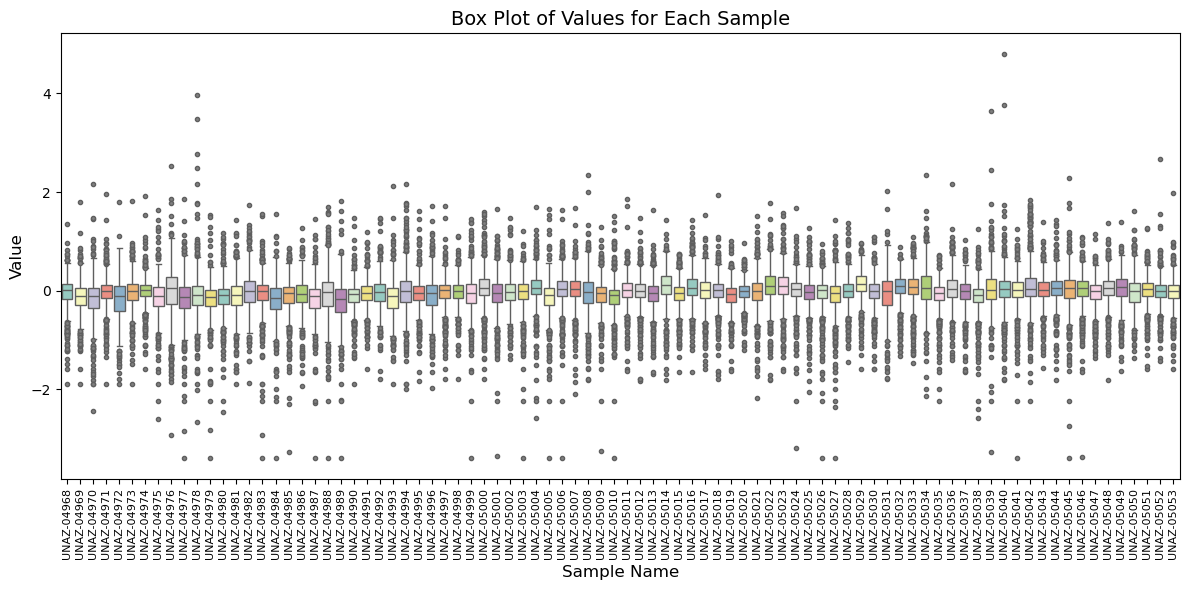

In [76]:
data_transposed = data.T

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_transposed, palette="Set3",flierprops=dict(marker='.', markerfacecolor='grey',linestyle='none'))
plt.title("Box Plot of Values for Each Sample", fontsize=14)
plt.xlabel("Sample Name", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(rotation=90,fontsize=8)  # Rotate sample names for better readability
plt.tight_layout() #Adjust the layout to prevent overlapping of labels.
plt.savefig(os.path.join(outputDir, "boxplot_samples.pdf"))
plt.show()

plt.close()

In [29]:
samples.columns

Index(['PARENT_SAMPLE_NAME', 'BOX_NUMBER', 'GENOTYPE', 'GROUP_ID',
       'GROUP_NAME', 'SAMPLE_BOX_LOCATION', 'SAMPLE_DESCRIPTION',
       'SAMPLE_STATUS', 'TIMEPOINT'],
      dtype='object')

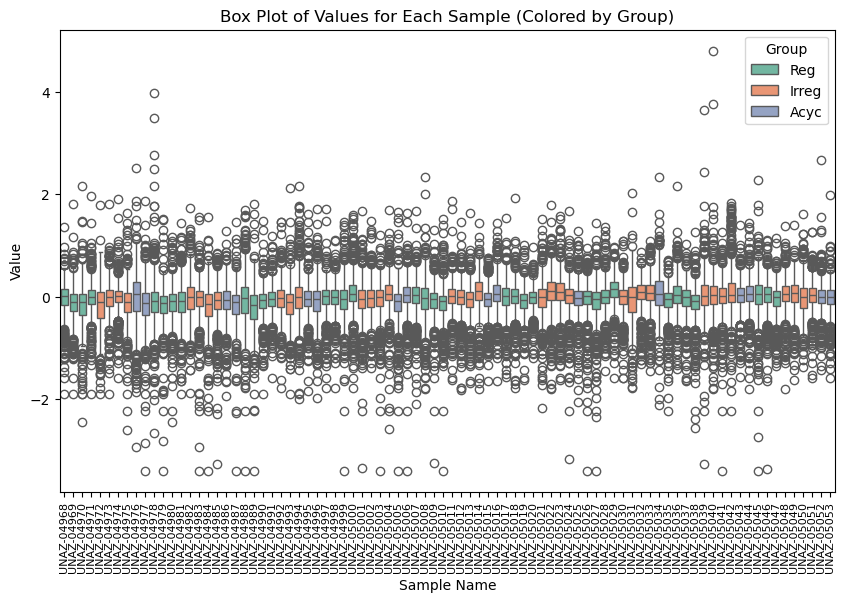

In [32]:
# Melt the data for seaborn
data_melted = data_transposed.melt(var_name="PARENT_SAMPLE_NAME", value_name="Value")

# Add group information

data_melted = data_melted.merge(samples, on="PARENT_SAMPLE_NAME", how="left")

# Create the box plot with group colors
plt.figure(figsize=(10, 6))
sns.boxplot(x="PARENT_SAMPLE_NAME", y="Value", hue="SAMPLE_STATUS", data=data_melted, palette="Set2")
plt.title("Box Plot of Values for Each Sample (Colored by Group)")
plt.xlabel("Sample Name")
plt.ylabel("Value")
plt.xticks(rotation=90,fontsize=8)
plt.legend(title="Group")
plt.show()

## PCA

Note for **confidence ellipses** that represent the distribution of points for each group. To achieve this, you can use the matplotlib.patches.Ellipse class and calculate the ellipse parameters (center, width, height, and angle) based on the mean and covariance of the data points for each group.

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from pandas.api.types import CategoricalDtype  # For categorical type checking

def plot_pca_triangular(pc_df,variance_explained, hue="group", alpha_dot=0.8, figsize=(15, 15),save_path="pca_plot.pdf"):
    """
    Plot 2D combinations of the first four principal components in a triangular arrangement,
    with points colored by a specified grouping column, explained variance in axis labels,
    and ellipses summarizing each group.

    Parameters:
        pc_df (pd.DataFrame): DataFrame containing PC1, PC2, PC3, PC4, and a grouping column.
        hue (str): Column name in pc_df to use for coloring points (default: "group").
        figsize (tuple): Size of the figure (default: (15, 15)).

    Returns:
        None (displays the plot).
    """
    # Check if the hue column exists in pc_df
    if hue not in pc_df.columns:
        raise ValueError(f"Column '{hue}' not found in pc_df.")

    # Convert the hue column to categorical if it's not already
    if not isinstance(pc_df[hue].dtype, CategoricalDtype):
        pc_df[hue] = pc_df[hue].astype('category')

    # Create a colormap for the categories
    categories = pc_df[hue].cat.categories
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
    cmap = ListedColormap(colors)

    # Create a figure with subplots arranged in a triangular shape
    fig, axs = plt.subplots(3, 3, figsize=figsize)

    # Remove unused subplots
    axs[0, 1].axis('off')  # Top-center subplot
    axs[0, 2].axis('off')  # Top-right subplot
    axs[1, 2].axis('off')  # Middle-right subplot


    # Function to plot confidence ellipses
    def plot_ellipse(ax, group_data, color, alpha=0.2):
        """
        Plot a confidence ellipse for a group of data points.
        """
        if len(group_data) < 2:
            return  # Not enough points to compute covariance

        # Calculate mean and covariance
        mean = np.mean(group_data, axis=0)
        cov = np.cov(group_data, rowvar=False)

        # Calculate eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Calculate the angle of the ellipse
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Calculate the width and height of the ellipse
        # Using chi-squared distribution for confidence level (e.g., 95%)
        confidence_level = 0.95
        scale = np.sqrt(chi2.ppf(confidence_level, 2))  # 2 degrees of freedom for 2D data
        width, height = 2 * scale * np.sqrt(eigenvalues)

        # Create and add the ellipse
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=alpha)
        ax.add_patch(ellipse)

    # Plot PC1 vs PC2
    scatter = axs[0, 0].scatter(pc_df['PC1'], pc_df['PC2'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC2']].values
        plot_ellipse(axs[0, 0], group_data, color=colors[i])
    axs[0, 0].set_title('PC1 vs PC2')
    axs[0, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[0, 0].set_ylabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[0, 0].grid(True)

    # Plot PC1 vs PC3
    axs[1, 0].scatter(pc_df['PC1'], pc_df['PC3'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC3']].values
        plot_ellipse(axs[1, 0], group_data, color=colors[i])
    axs[1, 0].set_title('PC1 vs PC3')
    axs[1, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[1, 0].set_ylabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[1, 0].grid(True)

    # Plot PC1 vs PC4
    axs[2, 0].scatter(pc_df['PC1'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC4']].values
        plot_ellipse(axs[2, 0], group_data, color=colors[i])
    axs[2, 0].set_title('PC1 vs PC4')
    axs[2, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[2, 0].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 0].grid(True)

    # Plot PC2 vs PC3
    axs[1, 1].scatter(pc_df['PC2'], pc_df['PC3'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC2', 'PC3']].values
        plot_ellipse(axs[1, 1], group_data, color=colors[i])
    axs[1, 1].set_title('PC2 vs PC3')
    axs[1, 1].set_xlabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[1, 1].set_ylabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[1, 1].grid(True)

    # Plot PC2 vs PC4
    axs[2, 1].scatter(pc_df['PC2'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC2', 'PC4']].values
        plot_ellipse(axs[2, 1], group_data, color=colors[i])
    axs[2, 1].set_title('PC2 vs PC4')
    axs[2, 1].set_xlabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[2, 1].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 1].grid(True)

    # Plot PC3 vs PC4
    axs[2, 2].scatter(pc_df['PC3'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC3', 'PC4']].values
        plot_ellipse(axs[2, 2], group_data, color=colors[i])
    axs[2, 2].set_title('PC3 vs PC4')
    axs[2, 2].set_xlabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[2, 2].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 2].grid(True)

    # Add a colorbar to the figure, positioned to the right of the subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=range(len(categories)))
    cbar.set_ticklabels(categories)
    cbar.set_label(hue)

    # Adjust layout and display the figure
    #plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
    plt.subplots_adjust(right=0.9)
    if save_path:
        # Extract the file extension
        file_extension = os.path.splitext(save_path)[1].lower()
        supported_formats = ['.pdf', '.png', '.svg', '.jpg', '.jpeg', '.tiff']

        if file_extension in supported_formats:
            plt.savefig(os.path.join(outputDir,save_path), format=file_extension[1:], bbox_inches='tight')
            print(f"Plot saved as {save_path}")
        else:
            raise ValueError(f"Unsupported file format: {file_extension}. Supported formats: {supported_formats}")

    plt.show()


In [42]:
# Perform PCA
pca = PCA(n_components=4)  # Reduce to 2 dimensions for visualization
pca_results = pca.fit_transform(data)

# Create a DataFrame for the PCA results

pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2","PC3","PC4"], index=data.index)
# Reset the index of pc_df to make it a column
pca_df = pca_df.reset_index().rename(columns={'index': 'PARENT_SAMPLE_NAME'})

# Merge sample_df with pc_df_reset on 'PARENT_SAMPLE_NAME'
pca_df = pd.merge(pca_df, samples, on='PARENT_SAMPLE_NAME', how='inner')
# Add group information to the PCA results
# TIMEPOINT, GENOTYPE, GROUP_ID, GROUP_NAME, SAMPLE_STATUS


Plot saved as status.pdf


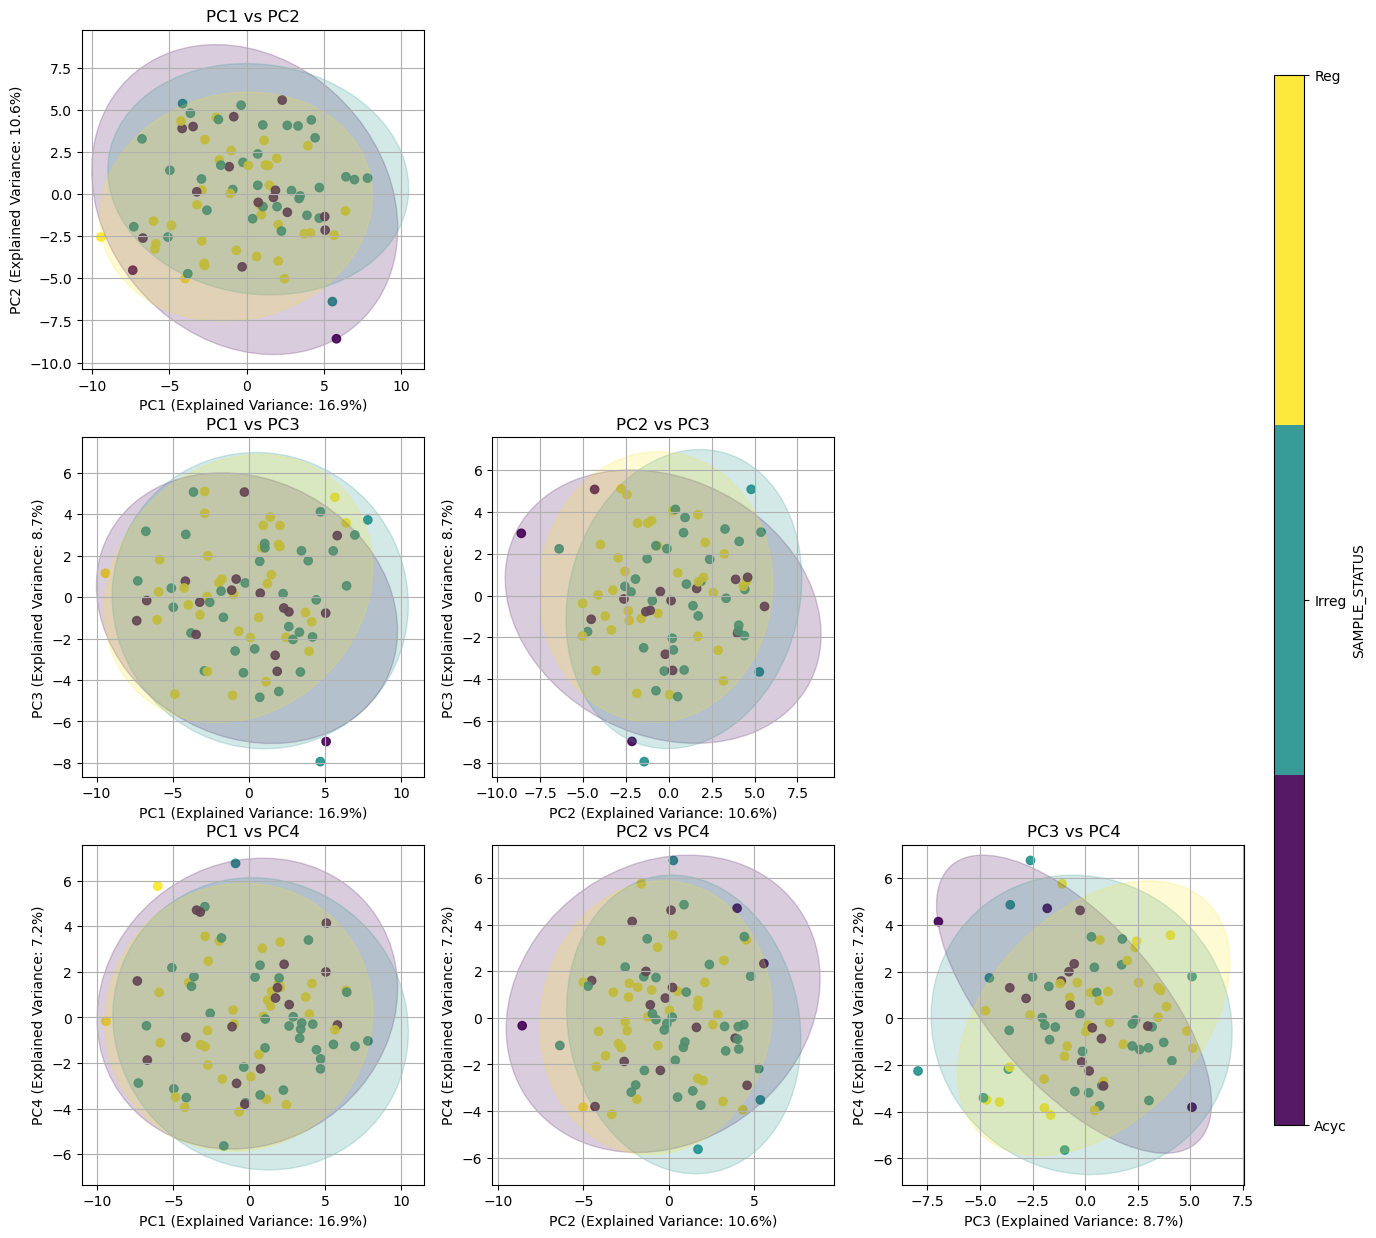

In [68]:
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue="SAMPLE_STATUS",alpha_dot=0.9,save_path="status.pdf")

Plot saved as GENOTYPE.pdf


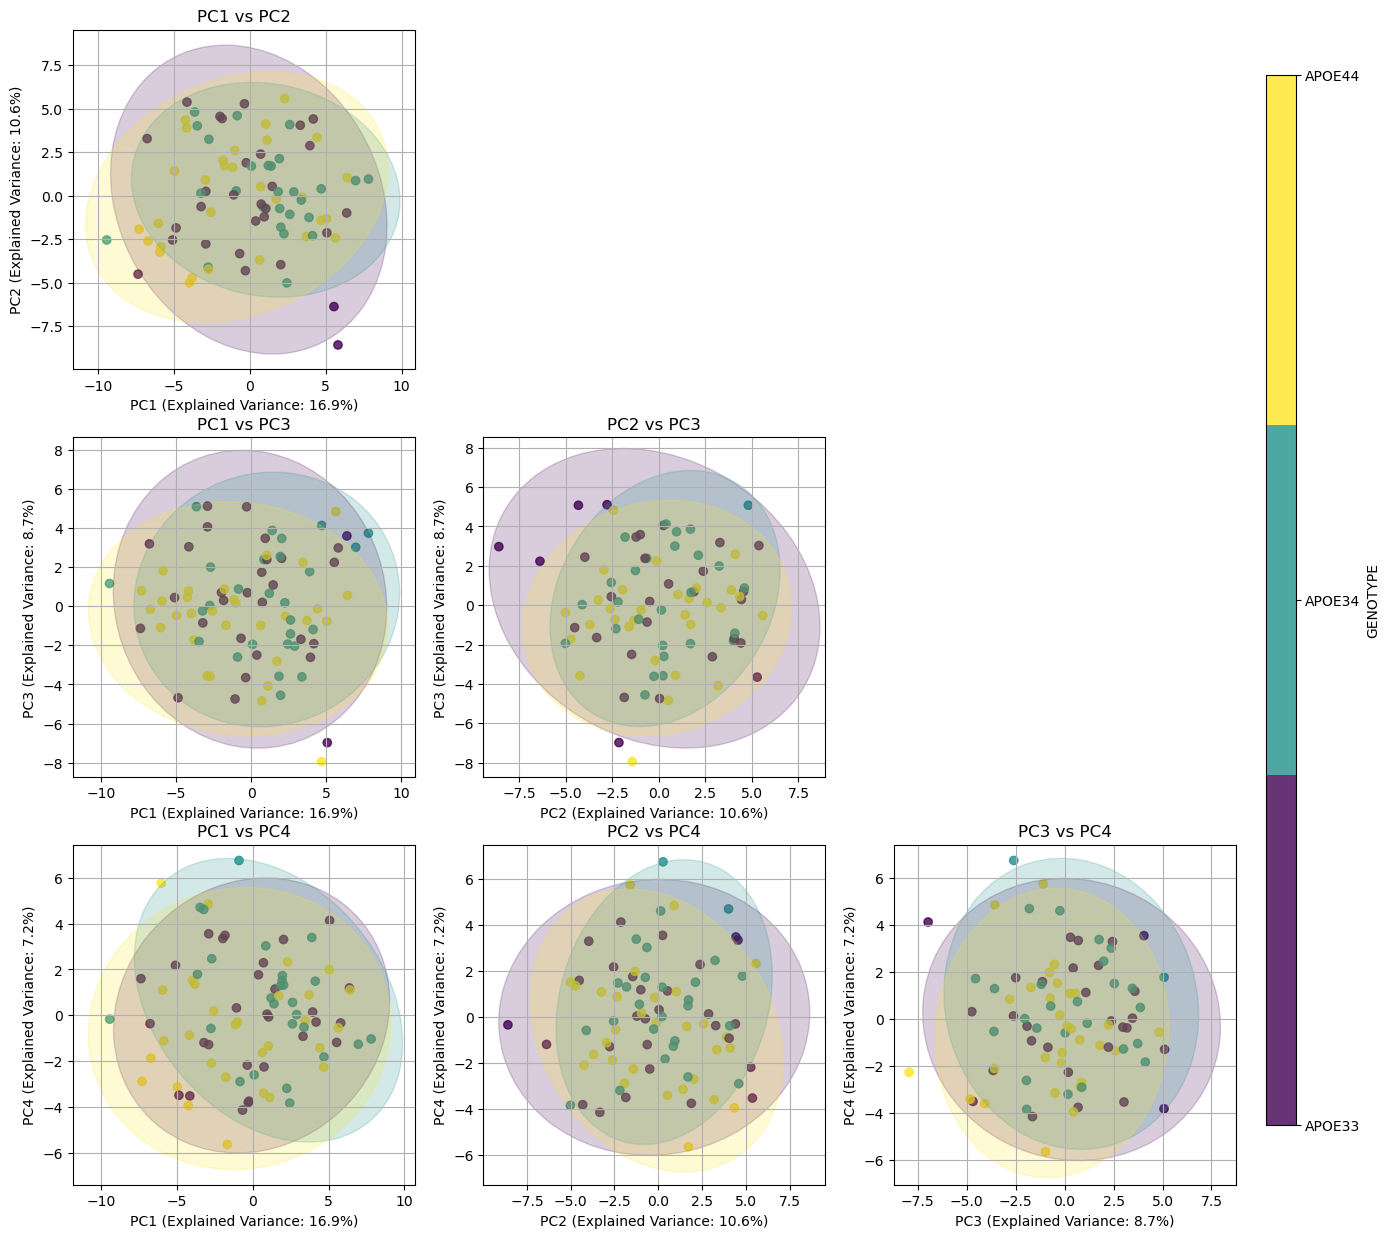

In [69]:
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue="GENOTYPE",save_path="GENOTYPE.pdf")

In [70]:
samples.columns

Index(['PARENT_SAMPLE_NAME', 'BOX_NUMBER', 'GENOTYPE', 'GROUP_ID',
       'GROUP_NAME', 'SAMPLE_BOX_LOCATION', 'SAMPLE_DESCRIPTION',
       'SAMPLE_STATUS', 'TIMEPOINT', 'sampleID'],
      dtype='object')

In [ ]:
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue="BOX_NUMBER",save_path="BOX_NUMBER.pdf")

Plot saved as BOX_NUMBER.pdf


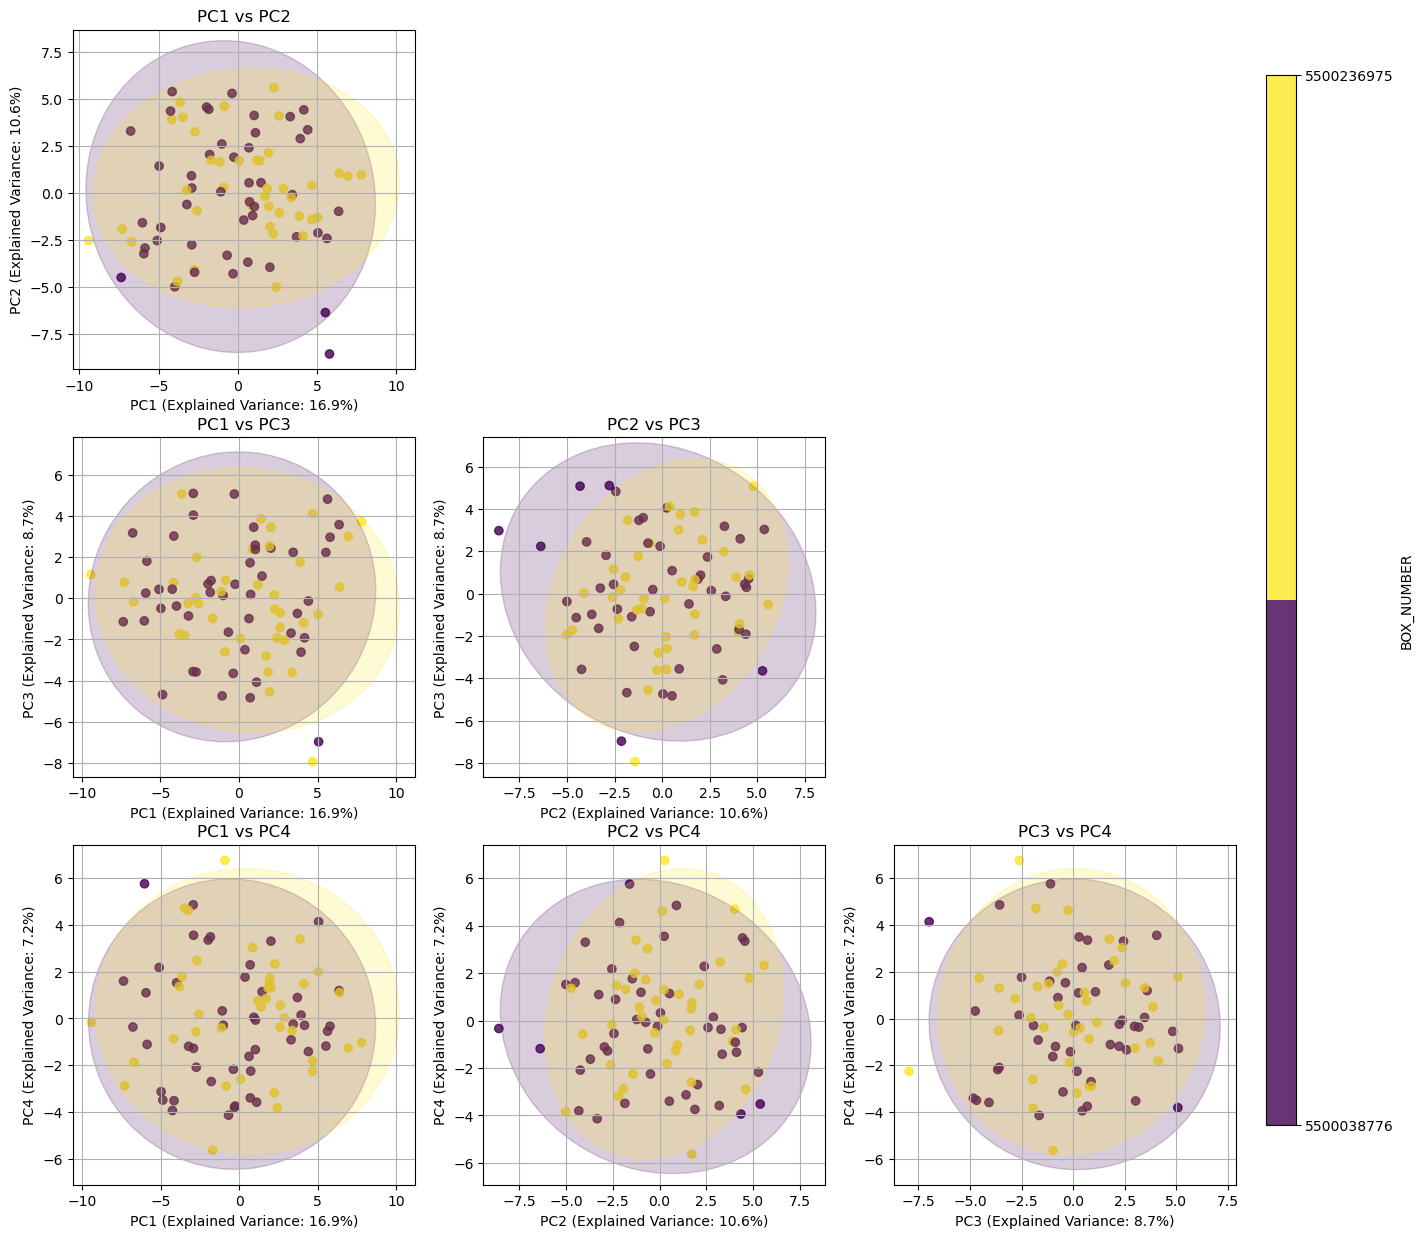

In [72]:
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue="BOX_NUMBER",save_path="BOX_NUMBER.pdf")

Plot saved as TIMEPOINT.pdf


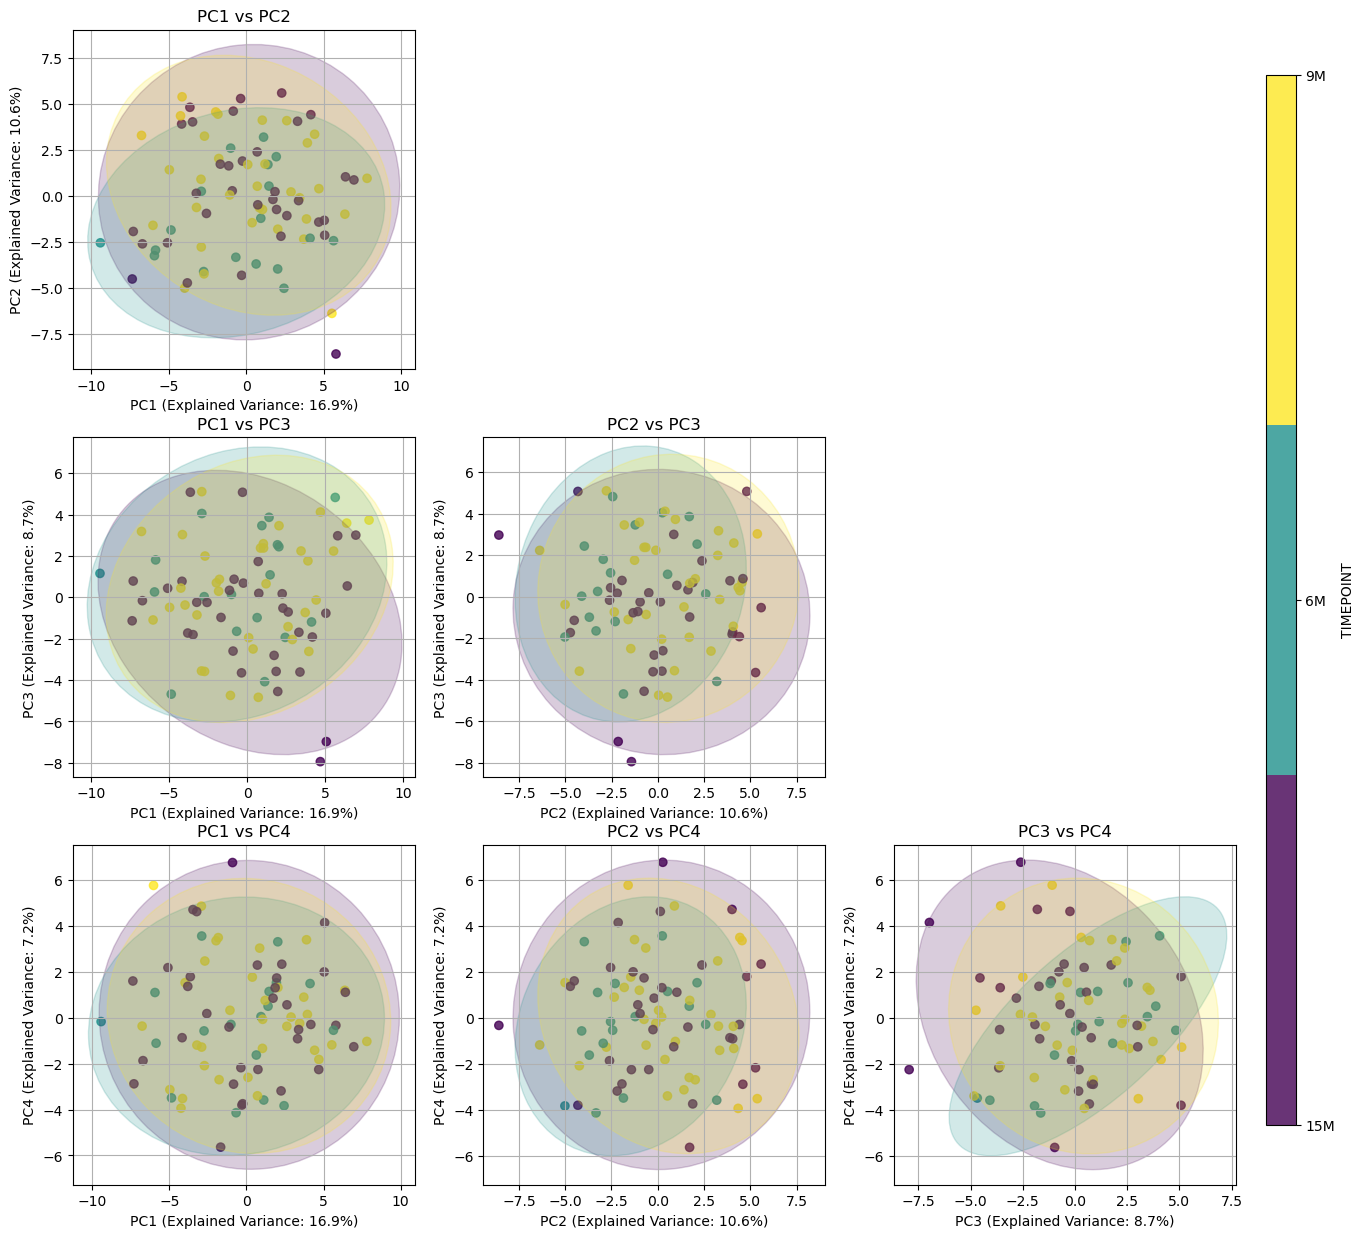

In [71]:
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue="TIMEPOINT",save_path="TIMEPOINT.pdf")

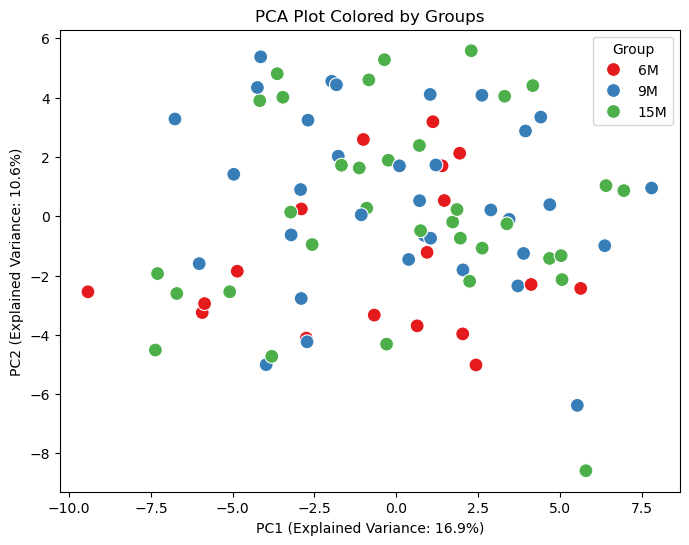

In [19]:
# Plot the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2", hue="group", data=pca_df, palette="Set1", s=100
)
plt.title("PCA Plot Colored by Groups")
plt.xlabel(f"PC1 (Explained Variance: {100*pca.explained_variance_ratio_[0]:.1f}%)")
plt.ylabel(f"PC2 (Explained Variance: {100*pca.explained_variance_ratio_[1]:.1f}%)")
plt.legend(title="Group")
plt.show()